In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from hydra.core.config_store import ConfigStore
from hydra_zen import builds, instantiate
from hydra_zen.experimental import hydra_run, hydra_multirun
from torch import nn
from torch.optim import SGD, Adadelta, Adagrad, Adam

In [2]:
SGDConf = builds(SGD, lr=0.3, momentum=0.5, hydra_partial=True)
AdadeltaConf = builds(Adadelta, lr=40, hydra_partial=True)
AdagradConf = builds(Adagrad, lr=0.3, hydra_partial=True)
AdamConf = builds(Adam, lr=0.1, hydra_partial=True)

cs = ConfigStore.instance()
cs.store(group="optim", name="sgd", node=SGDConf)
cs.store(group="optim", name="adadelta", node=AdadeltaConf)
cs.store(group="optim", name="adagrad", node=AdagradConf)
cs.store(group="optim", name="adam", node=AdamConf)

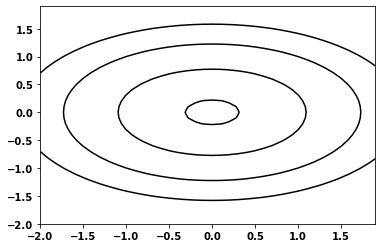

In [3]:
class Model:
    def __call__(self, z):
        if z.ndim == 2:
            x = z[:, 0]
            y = z[:, 1]
        else:
            x = z[0]
            y = z[1]
        return 0.1 * x ** 2 + 0.2 * y ** 2


x, y = np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.stack((X.flatten(), Y.flatten()), 1)
V = Model()(Z)
plt.contour(
    X, Y, V.reshape(len(x), len(y)), levels=[0.01, 0.12, 0.3, 0.5], colors="black"
)

In [4]:
def task_function(cfg):
    f = instantiate(cfg.model)
    x0 = torch.tensor([-1.5, 0.5]).requires_grad_(True)
    optim = instantiate(cfg.optim)([x0])
    trajectory = [x0.detach().clone().numpy()]
    for i in range(20):
        l = f(x0)
        optim.zero_grad()
        l.backward()
        optim.step()
        trajectory.append(x0.detach().clone().numpy())
    return np.stack(trajectory)

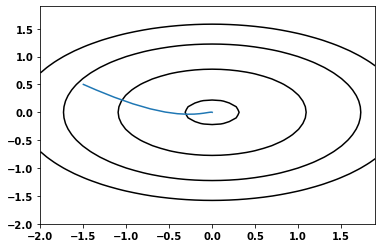

In [5]:
cfg = dict(model=builds(Model), optim=SGDConf(lr=0.5))
job = hydra_run(cfg, task_function)

fig, ax = plt.subplots()
ax.contour(
    X, Y, V.reshape(len(x), len(y)), levels=[0.01, 0.12, 0.3, 0.5], colors="black"
)
ax.plot(job.return_value[:, 0], job.return_value[:, 1])

[2021-04-21 13:29:34,456][HYDRA] Launching 4 jobs locally
[2021-04-21 13:29:34,458][HYDRA] 	#0 : +optim=sgd
[2021-04-21 13:29:34,539][HYDRA] 	#1 : +optim=adam
[2021-04-21 13:29:34,620][HYDRA] 	#2 : +optim=adagrad
[2021-04-21 13:29:34,701][HYDRA] 	#3 : +optim=adadelta


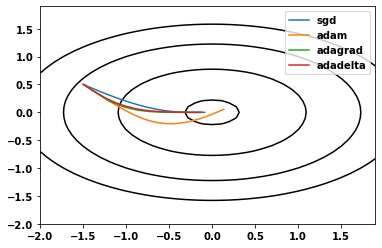

In [6]:
# NOTE: You have to set optim=None for multirun to work (omegaconf complains about merging with different types)
Config = dict(model=builds(Model), optim=None)
jobs = hydra_multirun(
    Config, task_function, overrides=["+optim=sgd,adam,adagrad,adadelta"]
)

fig, ax = plt.subplots()
ax.contour(
    X, Y, V.reshape(len(x), len(y)), levels=[0.01, 0.12, 0.3, 0.5], colors="black"
)
for j in jobs[0]:
    ax.plot(
        j.return_value[:, 0],
        j.return_value[:, 1],
        label=j.hydra_cfg.hydra.overrides.task[0].split("=")[1],
    )

plt.legend()

In [7]:
# !rm -rf outputs/ multirun/

# Docstring Tests

In [8]:
job = hydra_run(builds(dict, a=1, b=1), task_function=lambda x: instantiate(x))
job.return_value

{'a': 1, 'b': 1}

In [9]:
job = hydra_multirun(
    builds(dict, a=1, b=1),
    task_function=lambda x: instantiate(x),
    overrides=["a=1,2"],
)
[j.return_value for j in job[0]]

[2021-04-21 13:29:35,187][HYDRA] Launching 2 jobs locally
[2021-04-21 13:29:35,188][HYDRA] 	#0 : a=1
[2021-04-21 13:29:35,257][HYDRA] 	#1 : a=2


[{'a': 1, 'b': 1}, {'a': 2, 'b': 1}]

In [10]:
cfg = dict(f=builds(pow, exp=2, hydra_partial=True), x=1)


def task_function(cfg):
    return instantiate(cfg.f)(cfg.x)


job = hydra_run(cfg, task_function)
job.return_value

1

In [11]:
jobs = hydra_multirun(cfg, task_function, overrides=["x=range(-2,3)"])
[j.return_value for j in jobs[0]]

[2021-04-21 13:29:35,666][HYDRA] Launching 5 jobs locally
[2021-04-21 13:29:35,666][HYDRA] 	#0 : x=-2
[2021-04-21 13:29:35,732][HYDRA] 	#1 : x=-1
[2021-04-21 13:29:35,799][HYDRA] 	#2 : x=0
[2021-04-21 13:29:35,869][HYDRA] 	#3 : x=1
[2021-04-21 13:29:35,939][HYDRA] 	#4 : x=2


[4, 1, 0, 1, 4]

In [12]:
from torch.optim import Adam
from torch.nn import Linear

AdamConfig = builds(Adam, lr=0.001, hydra_partial=True)
ModelConfig = builds(Linear, in_features=1, out_features=1)
cfg = dict(optim=AdamConfig(), model=ModelConfig())


def task_function(cfg):
    model = instantiate(cfg.model)
    optim = instantiate(cfg.optim)(model.parameters())
    loss = model(torch.ones(1)).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss.item()


jobs = hydra_multirun(cfg, task_function, overrides=["optim.lr=0.1,1.0"])
[j.return_value for j in jobs[0]]

[2021-04-21 13:29:36,234][HYDRA] Launching 2 jobs locally
[2021-04-21 13:29:36,235][HYDRA] 	#0 : optim.lr=0.1
[2021-04-21 13:29:36,308][HYDRA] 	#1 : optim.lr=1.0


[-0.9879177808761597, -0.6828279495239258]

In [13]:
jobs = hydra_multirun(
    builds(dict, a=1, b=1),
    task_function=lambda x: instantiate(x),
    overrides=["hydra/sweeper=basic", "hydra.sweeper.max_batch_size=1", "a=1,2"],
)

[2021-04-21 13:29:36,489][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:36,489][HYDRA] 	#0 : a=1
[2021-04-21 13:29:36,598][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:36,599][HYDRA] 	#1 : a=2


In [14]:
!rm -rf outputs/ multirun/

## Readme

In [15]:
# Setting up our code...
# This does not involve hydra-zen in any way.
import torch
import numpy

# This is the function that we will run under various configurations 
# in order to perform our analysis.
def gradient_descent(*, starting_xy, optim, num_steps, landscape_fn):
    """
    Parameters
    ----------
    starting_xy : Tuple[float, float]
    optim : Type[torch.optim.Optimizer]
    num_steps : int
    landscape_fn : (x: Tensor, y: Tensor) -> Tensor
    
    Returns
    -------
    xy_trajectory: ndarray, shape-(num_steps + 1, 2)
    """
    xy = torch.tensor(starting_xy, requires_grad=True)
    trajectory = [xy.detach().clone().numpy()]
    
    # `optim` needs to be instantiated with 
    # the tensor parameter(s) to be updated
    optim: torch.optim.Optimizer = optim([xy])

    for i in range(num_steps):
        z = landscape_fn(*xy)
        optim.zero_grad()
        z.backward()
        optim.step()
        trajectory.append(xy.detach().clone().numpy())
    return numpy.stack(trajectory)


# defines our surface that we will be descending
def parabaloid(x, y):
    return 0.1 * x ** 2 + 0.2 * y ** 2

In [16]:
# Using hydra-zen to configure our code

from torch.optim import SGD

from hydra_zen import builds, just

# Defines dataclasses that configure `gradient_descent`
# and its parameters. Invalid parameter names will be caught here.
ConfigGradDesc = builds(
    gradient_descent,

    # Configured to only partially build `SGD`.
    # Not all of its required inputs are part of our configuration
    optim=builds(SGD, lr=0.3, momentum=0.0, hydra_partial=True),

    landscape_fn=just(parabaloid),
    starting_xy=(-1.5, 0.5),
    num_steps=20,
)

# `hydra_zen.typing` provides: `Builds`, `PartialBuilds`, and `Just` 
# 
# ConfigGradDesc              : Type[Builds[Type[gradient_descent]]]
# ConfigGradDesc.optim        : Type[PartialBuilds[Type[SGD]]]
# ConfigGradDesc.landscape_fn : Type[Just[Type[parabaloid]]]
# ConfigGradDesc.starting_xy  : Tuple[int, int]
# ConfigGradDesc.num_steps    : int

In [17]:
from hydra_zen import instantiate
instantiate(ConfigGradDesc)

array([[-1.5       ,  0.5       ],
       [-1.41      ,  0.44      ],
       [-1.3254    ,  0.3872    ],
       [-1.245876  ,  0.340736  ],
       [-1.1711234 ,  0.29984766],
       [-1.100856  ,  0.26386595],
       [-1.0348046 ,  0.23220204],
       [-0.97271633,  0.20433779],
       [-0.9143534 ,  0.17981726],
       [-0.8594922 ,  0.15823919],
       [-0.80792266,  0.13925049],
       [-0.7594473 ,  0.12254043],
       [-0.7138804 ,  0.10783558],
       [-0.67104757,  0.0948953 ],
       [-0.6307847 ,  0.08350787],
       [-0.5929376 ,  0.07348692],
       [-0.5573613 ,  0.06466849],
       [-0.52391964,  0.05690827],
       [-0.49248445,  0.05007928],
       [-0.4629354 ,  0.04406976],
       [-0.43515927,  0.03878139]], dtype=float32)

In [18]:
from hydra_zen.experimental import hydra_run, hydra_multirun
job = hydra_run(
    ConfigGradDesc,
    task_function=instantiate,
    overrides=["hydra.run.dir=outputs/gradient_descent", "optim.momentum=0.2"],
)

In [19]:
job.return_value

array([[-1.5       ,  0.5       ],
       [-1.41      ,  0.44      ],
       [-1.3074    ,  0.3752    ],
       [-1.208436  ,  0.317216  ],
       [-1.116137  ,  0.26755327],
       [-1.030709  ,  0.22551434],
       [-0.95178086,  0.19004482],
       [-0.87888837,  0.16014554],
       [-0.81157655,  0.13494821],
       [-0.74941957,  0.11371496],
       [-0.692023  ,  0.09582251],
       [-0.6390223 ,  0.08074532],
       [-0.5900808 ,  0.06804045],
       [-0.54488766,  0.05733462],
       [-0.50315577,  0.0483133 ],
       [-0.46462005,  0.04071144],
       [-0.4290357 ,  0.03430569],
       [-0.39617667,  0.02890786],
       [-0.36583427,  0.02435935],
       [-0.33781573,  0.02052652],
       [-0.31194308,  0.01729678]], dtype=float32)

In [20]:
jobs = hydra_multirun(
    ConfigGradDesc,
    task_function=instantiate,
    overrides=["hydra/sweeper=basic", "hydra.sweeper.max_batch_size=1", "optim.momentum=range(0.0,1.2,0.2)"],
)

[2021-04-21 13:29:37,240][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:37,241][HYDRA] 	#0 : optim.momentum=0.0
[2021-04-21 13:29:37,364][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:37,365][HYDRA] 	#1 : optim.momentum=0.2
[2021-04-21 13:29:37,489][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:37,489][HYDRA] 	#2 : optim.momentum=0.4
[2021-04-21 13:29:37,614][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:37,614][HYDRA] 	#3 : optim.momentum=0.6000000000000001
[2021-04-21 13:29:37,739][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:37,740][HYDRA] 	#4 : optim.momentum=0.8
[2021-04-21 13:29:37,864][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:37,864][HYDRA] 	#5 : optim.momentum=1.0


In [21]:
import torch
from omegaconf import OmegaConf
from dataclasses import dataclass
from typing import Any

In [22]:
# @dataclass
# class ExpConfig:
#     optim: Any = builds(torch.optim.SGD, hydra_partial=True)


# exp = OmegaConf.create(ExpConfig)
# exp = OmegaConf.merge(exp, dict(optim=builds(torch.optim.Adam, hydra_partial=True)))
# print(OmegaConf.to_yaml(exp))

In [23]:
from dataclasses import dataclass
from typing import Any

from torch.optim import Adam
from torchvision.models import resnet18
from torchvision.datasets import ImageNet
from torchvision.transforms import (
    Compose,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
    Normalize,
)

from hydra_zen import builds, instantiate

import io
from PIL import Image
import requests

# example image url: https://m.media-amazon.com/images/S/aplus-media/vc/6a9569ab-cb8e-46d9-8aea-a7022e58c74a.jpg
def download_image(url):
    r = requests.get(url, timeout=10.0)
    if r.status_code != requests.codes.ok:
        assert False, "Status code error: {}.".format(r.status_code)

    return Image.open(io.BytesIO(r.content))


@dataclass
class ExperimentConfig:
    img_downloader: Any = builds(download_image, hydra_partial=True)
    model: Any = builds(resnet18, pretrained=True)
    transform: Any = builds(
        Compose,
        transforms=[
            builds(Resize, size=(224, 224), populate_full_signature=True),
            builds(ToTensor),
            builds(Normalize, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ],
    )


exp = instantiate(ExperimentConfig)
exp.model.eval()
im = exp.img_downloader(
    "https://miro.medium.com/max/1050/1*8HtYIE3lmSjrBz51Bb6iaA.jpeg"
)

logit = exp.model(exp.transform(im).unsqueeze(0))
logit.argmax(1)
# model = instantiate(ExperimentConfig.model)
# model.eval()

# transform = instantiate(ExperimentConfig.transform)
# im = instantiate(ExperimentConfig.img_downloader)("https://miro.medium.com/max/1050/1*8HtYIE3lmSjrBz51Bb6iaA.jpeg")

# logit = model(transform(im).unsqueeze(0))
# logit.argmax(1)

tensor([671])

[2021-04-21 13:29:38,759][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:38,760][HYDRA] 	#0 : x=1.2076944747603555 y=-6.090403175328667
[2021-04-21 13:29:38,838][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:38,839][HYDRA] 	#1 : x=3.470556599748331 y=-0.049273013953929024
[2021-04-21 13:29:38,913][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:38,913][HYDRA] 	#2 : x=8.294927460373103 y=2.051840862337837
[2021-04-21 13:29:38,989][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:38,989][HYDRA] 	#3 : x=-11.160143680977859 y=-2.121006710645883
[2021-04-21 13:29:39,063][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:39,063][HYDRA] 	#4 : x=0.00695774593900822 y=-9.69543900086435
[2021-04-21 13:29:39,138][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:39,138][HYDRA] 	#5 : x=10.107098349408442 y=0.042459379225846305
[2021-04-21 13:29:39,216][HYDRA] Launching 1 jobs locally
[2021-04-21 13:29:39,216][HYDRA] 	#6 : x=6.8744140890696315 y=11.143249318538182
[2021-04-21 13:29:39,291

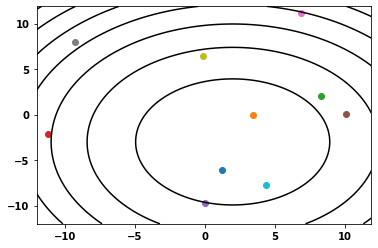

In [24]:
from typing import List, Optional, Any

from hydra import TaskFunction
from hydra.core.config_loader import ConfigLoader
from hydra.plugins.sweeper import Sweeper
from omegaconf import DictConfig
from hydra.core.plugins import Plugins
from hydra.core.override_parser.overrides_parser import OverridesParser

import random
import numpy as np
from dataclasses import dataclass
from hydra_zen import builds


@dataclass
class ExperimentConfig:
    x: float = 0.0
    y: float = 12.0
    maximize: bool = False
    max_iter: int = 10


class SearcherSweeper(Sweeper):
    def __init__(self, optim: ExperimentConfig):
        self.opt_config = optim
        self.config: Optional[DictConfig] = None
        self.launcher: Optional[Launcher] = None
        self.job_idx: Optional[int] = None

    def setup(
        self,
        config: DictConfig,
        config_loader: ConfigLoader,
        task_function: TaskFunction,
    ) -> None:
        self.job_idx = 0
        self.config = config
        self.config_loader = config_loader
        
        self.launcher = instantiate(config.hydra.launcher)
        # assert isinstance(launcher, Launcher)
        self.launcher.setup(
            config=config,
            config_loader=config_loader,
            task_function=task_function,
        )       

    def sweep(self, arguments: List[str]) -> None:
        parser = OverridesParser.create()
        parsed = parser.parse_overrides(arguments)

        param_bounds = {}
        for override in parsed:
            key = override.get_key_element()
            val = override.value()
            if override.is_interval_sweep():
                param_bounds[key] = [val.start, val.end]

        direction = -1 if self.opt_config.maximize else 1
        name = "maximization" if self.opt_config.maximize else "minimization"

        all_results = []
        best_score = None
        best_solution = None
        iterations = 0
        while iterations < self.opt_config.max_iter:
            new_solution = {k: random.uniform(*v) for k, v in param_bounds.items()}

            overrides = [tuple(f"{k}={float(v)}" for k, v in new_solution.items())]

            returns = self.launcher.launch(overrides, initial_job_idx=self.job_idx)
            score = returns[0].return_value

            if best_score is None:
                best_score = score
                best_solution = new_solution
            elif score > best_score and self.opt_config.maximize:
                best_score = score
                best_solution = new_solution
            elif score < best_score and not self.opt_config.maximize:
                best_score = score
                best_solution = new_solution

            self.job_idx += len(returns)
            iterations += 1
            all_results.append(new_solution)

        results_to_serialize = {
            "best_evaluated_params": best_solution,
            "best_evaluated_result": best_score,
        }
        return results_to_serialize, all_results


#         OmegaConf.save(
#             OmegaConf.create(results_to_serialize),
#             f"{self.config.hydra.sweep.dir}/optimization_results.yaml",
#         )


from hydra.core.config_store import ConfigStore
from hydra_zen.experimental import hydra_multirun

cs = ConfigStore.instance()
cs.store(
    group="hydra/sweeper",
    name="test_sweeper",
    node=builds(SearcherSweeper, optim=ExperimentConfig),
)


def square(x, y, z=12):
    return (x - 2) ** 2 + (y + 3) ** 2 + abs(z)


task_function = lambda cfg: square(cfg.x, cfg.y)
job = hydra_multirun(
    ExperimentConfig,
    task_function,
    overrides=["hydra/sweeper=test_sweeper", "x=interval(-12, 12)", "y=interval(-12, 12)"],
)


def plot_contours(ax):
    x, y = np.arange(-12, 12, 0.1), np.arange(-12, 12, 0.1)
    X, Y = np.meshgrid(x, y)
    V = square(X, Y)
    ax.contour(X, Y, V.reshape(len(x), len(y)), colors="black")


fig, ax = plt.subplots()
plot_contours(ax)

for s in job[1]:
    plt.scatter([s["x"]], [s["y"]])
#     plt.scatter([job['best_evaluated_params']['x']], [job['best_evaluated_params']['y']])

In [25]:
from hydra_zen import hydrated_dataclass, mutable_value

In [26]:
def objective(x, y, z=3):
    return (x - 2) ** 2 + (y + z) ** 2


def random_search(fun, x_bound, y_bound, maximize, max_iter):
    param_bounds = dict(x=x_bound, y=y_bound)

    all_results = []
    best_score = 1e100
    best_solution = None
    iterations = 0
    while iterations < max_iter:
        new_solution = {k: random.uniform(*v) for k, v in param_bounds.items()}
        score = fun(**new_solution)

        if score < best_score:
            best_score = score
            best_solution = new_solution

        iterations += 1
        all_results.append(new_solution)

    result = {
        "best_params": best_solution,
        "best_score": best_score,
    }
    return result, all_results


ObjectiveConfig = builds(objective, z=12, hydra_partial=True)


@hydrated_dataclass(random_search)
class ExpConfig:
    fun: Any = ObjectiveConfig
    x_bound: Any = mutable_value([-12, 12])
    y_bound: Any = mutable_value([-12, 12])
    maximize: bool = False
    max_iter: int = 10


instantiate(ExpConfig)

({'best_params': {'x': 0.05642254150610526, 'y': -11.185232600322227},
  'best_score': 4.441339252743267},
 [{'x': 0.05642254150610526, 'y': -11.185232600322227},
  {'x': -10.46229513214454, 'y': 3.322723031008305},
  {'x': -8.857571328605292, 'y': -1.1185631874122528},
  {'x': -7.650585512187893, 'y': -4.547407510481627},
  {'x': 8.771591317337382, 'y': -6.978421678429245},
  {'x': -11.415429330156183, 'y': -7.392980554734474},
  {'x': 10.023971350896577, 'y': -8.829690760472676},
  {'x': -9.082163612788019, 'y': -2.3021598981992426},
  {'x': -11.803679013847932, 'y': 10.97236348842237},
  {'x': 7.328720740512466, 'y': 0.8037571770954912}])

In [27]:
task_function = lambda cfg: instantiate(cfg)
jobs = hydra_multirun(
    ExpConfig,
    task_function,
    overrides=["fun.z=-5,1,4,8"],
)

[2021-04-21 13:29:39,944][HYDRA] Launching 4 jobs locally
[2021-04-21 13:29:39,945][HYDRA] 	#0 : fun.z=-5
[2021-04-21 13:29:40,019][HYDRA] 	#1 : fun.z=1
[2021-04-21 13:29:40,092][HYDRA] 	#2 : fun.z=4
[2021-04-21 13:29:40,164][HYDRA] 	#3 : fun.z=8


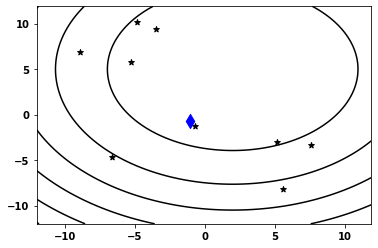

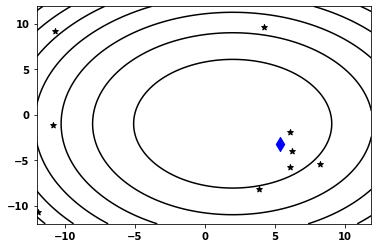

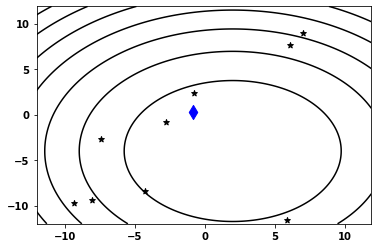

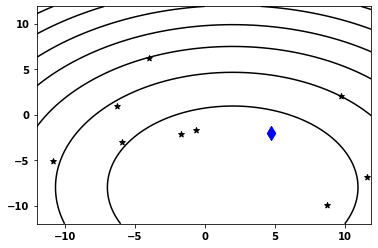

In [28]:
def plot_contours(z, ax):
    x, y = np.arange(-12, 12, 0.1), np.arange(-12, 12, 0.1)
    X, Y = np.meshgrid(x, y)
    V = objective(X, Y, z)
    ax.contour(X, Y, V.reshape(len(x), len(y)), colors="black")


for job in jobs[0]:
    fig, ax = plt.subplots()
    plot_contours(job.cfg.fun.z, ax)

    for s in job.return_value[1]:
        plt.scatter([s["x"]], [s["y"]], marker="*", color="k")

    res = job.return_value[0]
    plt.scatter(
        [res["best_params"]["x"]],
        [res["best_params"]["y"]],
        s=100,
        marker="d",
        color="b",
    )

In [29]:
from dataclasses import dataclass
from typing import Any, Tuple

from torch.optim import SGD

from hydra_zen import builds, just

# defines our surface that we will be descending
def parabaloid(x, y):
    return 0.1 * x ** 2 + 0.2 * y ** 2


# defines the configuration for our experiment
@dataclass
class ExpConfig:
    starting_xy: Tuple[float, float] = (-1.5, 0.5)
    num_steps: int = 20
    optim: Any = builds(SGD, lr=0.3, momentum=0.0, hydra_partial=True)
    landscape_fn: Any = just(parabaloid)

In [30]:
import torch as tr
import numpy as np


def gradient_descent(*, starting_xy, optim, num_steps, landscape_fn):
    """Performs gradient descent down `landscape_fn`, and returns a trajectory
    of x,y values"""
    xy = tr.tensor(starting_xy, requires_grad=True)
    trajectory = [xy.detach().clone().numpy()]

    # `optim` is only partially instantiated and needs
    # to be passed the tensor parameter
    optim = optim([xy])

    for i in range(num_steps):
        z = landscape_fn(*xy)
        optim.zero_grad()
        z.backward()
        optim.step()
        trajectory.append(xy.detach().clone().numpy())
    return np.stack(trajectory)

In [31]:
from hydra_zen import instantiate
from hydra_zen.experimental import hydra_multirun

jobs = hydra_multirun(
    ExpConfig,
    task_function=lambda cfg: gradient_descent(**instantiate(cfg)),
    overrides=["optim.momentum=0.0,0.2,0.4,0.6,0.8,1.0"],
)

[2021-04-21 13:29:41,102][HYDRA] Launching 6 jobs locally
[2021-04-21 13:29:41,102][HYDRA] 	#0 : optim.momentum=0.0
[2021-04-21 13:29:41,179][HYDRA] 	#1 : optim.momentum=0.2
[2021-04-21 13:29:41,256][HYDRA] 	#2 : optim.momentum=0.4
[2021-04-21 13:29:41,332][HYDRA] 	#3 : optim.momentum=0.6
[2021-04-21 13:29:41,409][HYDRA] 	#4 : optim.momentum=0.8
[2021-04-21 13:29:41,485][HYDRA] 	#5 : optim.momentum=1.0


In [32]:
jobs[0][1].return_value

array([[-1.5       ,  0.5       ],
       [-1.41      ,  0.44      ],
       [-1.3074    ,  0.3752    ],
       [-1.208436  ,  0.317216  ],
       [-1.116137  ,  0.26755327],
       [-1.030709  ,  0.22551434],
       [-0.95178086,  0.19004482],
       [-0.87888837,  0.16014554],
       [-0.81157655,  0.13494821],
       [-0.74941957,  0.11371496],
       [-0.692023  ,  0.09582251],
       [-0.6390223 ,  0.08074532],
       [-0.5900808 ,  0.06804045],
       [-0.54488766,  0.05733462],
       [-0.50315577,  0.0483133 ],
       [-0.46462005,  0.04071144],
       [-0.4290357 ,  0.03430569],
       [-0.39617667,  0.02890786],
       [-0.36583427,  0.02435935],
       [-0.33781573,  0.02052652],
       [-0.31194308,  0.01729678]], dtype=float32)

In [33]:
from hydra.experimental import compose, initialize_config_dir
from pathlib import Path

path = Path(jobs[0][0].working_dir) / ".hydra"
with initialize_config_dir(config_dir=str(path.absolute())):
    cfg_from_yaml = compose("config")

reproduced_job = hydra_run(
    cfg_from_yaml,
    task_function=lambda cfg: gradient_descent(**instantiate(cfg)),
)

np.all(reproduced_job.return_value == jobs[0][0].return_value)

True

In [34]:
!rm -rf outputs multirun